In [1]:
import seaborn as sns  #Visualization
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import math
import matplotlib


import pandas as pd   #preprocessing
import numpy as np
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.preprocessing import MinMaxScaler


import torch          #modelling
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from IMV_LSTM import IMVTensorLSTM
from IMV_LSTM import IMVFullLSTM

from boruta import BorutaPy
from BorutaShap import BorutaShap

import shap
import shap.plots

import operator

import time

import os
from IPython.utils import io

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ['#01BEFE','#FFDD00','#FF7D00','#FF006D','#ADFF02','#8F00FF']

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=12,8

tqdm.pandas()

In [3]:
folder_path = 'Predictions/Single_Run'

try:
    os.mkdir(f'{folder_path}')
except:
    pass

N_EPOCHS = 1001
BATCH_SIZE = 7
SEQUENCE_LENGTH = 15
N_HIDDEN = 32
N_LAYERS = 1
PATIENCE = 50
LEARNING = 0.001

TGT = 'Sales'

Train = False


Correlation = True

BorutaGB = True
BorutaRF = True

BorutaSHAPGB = True
BorutaSHAPRF = True

LSTM_SHAP = True
LSTM_LIME_ = True

IMV_Tensor = True
IMV_Full = True

In [4]:
torch.manual_seed(0)
np.random.seed(0)
pl.seed_everything(0);

Global seed set to 0


In [5]:
def features_dataframe(df, corr):
    rows = []
    '''
    ['rec_id', 'Date', 'year', 'month', 'temp', 'atemp', 'humidity', 'windspeed', TGT,
    'season_1', 'season_2', 'season_3', 'season_4', 'is_workingday_0', 'is_workingday_1', 'is_holiday_0',
    'is_holiday_1', 'weather_condition_1', 'weather_condition_2', 'weather_condition_3', 'weekday_0',
    'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'day']
    
    '''

    for _, row in df.iterrows():
        row_data = dict(
            Sales = row.Sales,
        )
        for column in corr:
            row_data[column] = row[column]
            
        rows.append(row_data)
    
    features_df = pd.DataFrame(rows)

    return features_df

#spliits the data in test and train
def train_test_spliter(ratio,features_df ):
    train_size = int(len(features_df)-ratio)
    train_df, test_df = features_df[:train_size], features_df[train_size + 1:]

    return train_df, test_df, train_size

def data_scaler(train_df,test_df):
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train_df)

    train_df = pd.DataFrame(
        scaler.transform(train_df),
        index = train_df.index,
        columns = train_df.columns
        )

    test_df = pd.DataFrame(
        scaler.transform(test_df),
        index = test_df.index,
        columns = test_df.columns
        )
    
    return train_df, test_df, scaler


def create_sequences (input_data:pd.DataFrame, target_column, sequence_length):
    sequences = []
    data_size = len(input_data)

    for i in (range(data_size - sequence_length)):

        sequence = input_data[i:i+sequence_length]

        label_position = i + sequence_length
        label = input_data.iloc[label_position][target_column]

        sequences.append((sequence,label))
    
    return sequences

def descale(descaler, values):
    values_2d=np.array(values)[:,np.newaxis]
    
    return descaler.inverse_transform(values_2d).flatten()


def dict_to_dataframe(dict_list,seq_size):
    
    column_names = []
    data = []
    
    for d in dict_list:
        features = d['sequence'].numpy().flatten()
        label = d['label'].numpy()
        data.append(np.concatenate((features, label), axis=None))
        
    df = pd.DataFrame(data)
    
    for j in range(seq_size):
        if seq_size-j >= 10:
            day_column_names = str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        else:
            day_column_names = '0' + str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        
    cols = [column_names + ['target']]
    df.columns = cols
    
    return df


def dict_to_dataframeBSHAP(dict_list,seq_size):
    
    column_names = []
    data = []
    
    for d in dict_list:
        features = d['sequence'].numpy().flatten()
        label = d['label'].numpy()
        data.append(np.concatenate((features, label), axis=None))
        
    df = pd.DataFrame(data)
    
    for j in range(seq_size):
        if seq_size-j >= 10:
            day_column_names = str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        else:
            day_column_names = '0' + str(seq_size-j) + 'day_back'+'_' + train_df.columns
            column_names.extend(day_column_names)
        
    column_names.append('target')
    df.columns = column_names
    
    return df


def LSTM_predict(array):
    with torch.no_grad():

        predictions_lime= list(array[:SEQUENCE_LENGTH,0])
        label_lime=[]

        train_df = pd.DataFrame(array)
        #features_df.columns = features

        train_sequences = create_sequences(train_df,0,SEQUENCE_LENGTH)

        data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)

        train_dataset = Dataset(train_sequences)

        data_module.setup()

        for item in train_dataset:
            sequence = item['sequence']
            label = item['label']
            _,output = trained_model(sequence.unsqueeze(dim=0))
            predictions_lime.append(output.item())
            label_lime.append(label.item())

        output = np.array(predictions_lime)

    return output

def LIME_Explainer(dates):
    features_evo = {col: [] for col in train_df.columns}
    
    for local in tqdm(range(dates,0,-1)):
        lst = explainer.explainer.explain_instance(train_df.iloc[-local],LSTM_predict).as_list()

        result = [(tup[0].split()) for tup in lst]

        for i in range(len(result)):
            if len(result[i]) == 3:
                features_evo[(train_df.columns[int(result[i][0])])].append(lst[i][1])
            else:
                features_evo[(train_df.columns[int(result[i][2])])].append(lst[i][1])

        for key in features_evo.keys():
            if len(features_evo[key]) < (dates - local)+1:
                features_evo[key].append(0)
                
    return features_evo


def return_shap_features(shap_values,train_df, number_to_return):
    shapdict = {}
    for k in train_df.columns:
        shapdict[k] = 0
        shapdict[f'{k}_count'] = 0


    for i in shap_values:
        for f in range(len(train_df.columns)):
            shapdict[train_df.columns[f]] += abs(i[f])
            shapdict[f'{train_df.columns[f]}_count'] += 1

    avg_n0_shap = {}

    for key in range(0,len(shapdict.keys()),2):
        if shapdict[list(shapdict.keys())[key+1]] != 0 and shapdict[list(shapdict.keys())[key]] != 0:
            avg_n0_shap[list(shapdict.keys())[key]] = shapdict[list(shapdict.keys())[key]]/shapdict[list(shapdict.keys())[key+1]]

    sorted_avg_shap = dict(sorted(avg_n0_shap.items(), key=operator.itemgetter(1), reverse=True))
    
    top_features = dict(sorted(avg_n0_shap.items(), key=lambda item: item[1], reverse=True)[:number_to_return])
    
    return sorted_avg_shap, top_features


    
def return_shap_max(shap_values,train_df):
    shapdict = {}
    for k in train_df.columns:
        shapdict[k] = []

    for i in shap_values:
        for f in range(len(train_df.columns)):
            shapdict[train_df.columns[f]].append(abs(i[f]))

    max_shap = {}
    for key in shapdict.keys():
        max_shap[key] = max(shapdict[key])

    max_shap_df = pd.DataFrame.from_dict(max_shap, orient='index', columns=['max_shap_value'])
    max_shap_df.index.name = 'feature_name'
    max_shap_df = max_shap_df.sort_values(by='max_shap_value', ascending=False)

    return max_shap_df


class Dataset(Dataset):

    def __init__(self,sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self,idx):
        sequence, label = self.sequences[idx]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

class SalesDataModule(pl.LightningDataModule):

    def __init__(self, train_seqeunces,test_sequences, batch_size=8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self,stage=None):
        self.train_dataset = Dataset(self.train_sequences)
        self.test_dataset = Dataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            shuffle = False,
            num_workers = 0
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers = 0
        )


class SalesPredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden = N_HIDDEN, n_layers = N_LAYERS):
        super().__init__()
        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            dropout = 0.2
        )
        self.regressor = nn.Linear(n_hidden,1)

    def forward(self,x):
        self.lstm.flatten_parameters()

        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]
        
        return self.regressor(out)
    

class SalesPredictor(pl.LightningModule):

    def __init__(self, n_features: int):
        super().__init__()
        self.model=SalesPredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels= None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))
        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('train_loss', loss, prog_bar = True, logger=False)
        return loss

    def validation_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('val_loss', loss, prog_bar = True, logger=False)
        return loss

    def test_step(self, batch, batch_index):
        sequences = batch['sequence']
        labels = batch['label']

        loss, outputs = self(sequences, labels)
        self.log('test_loss', loss, prog_bar = True, logger=False)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr = LEARNING)


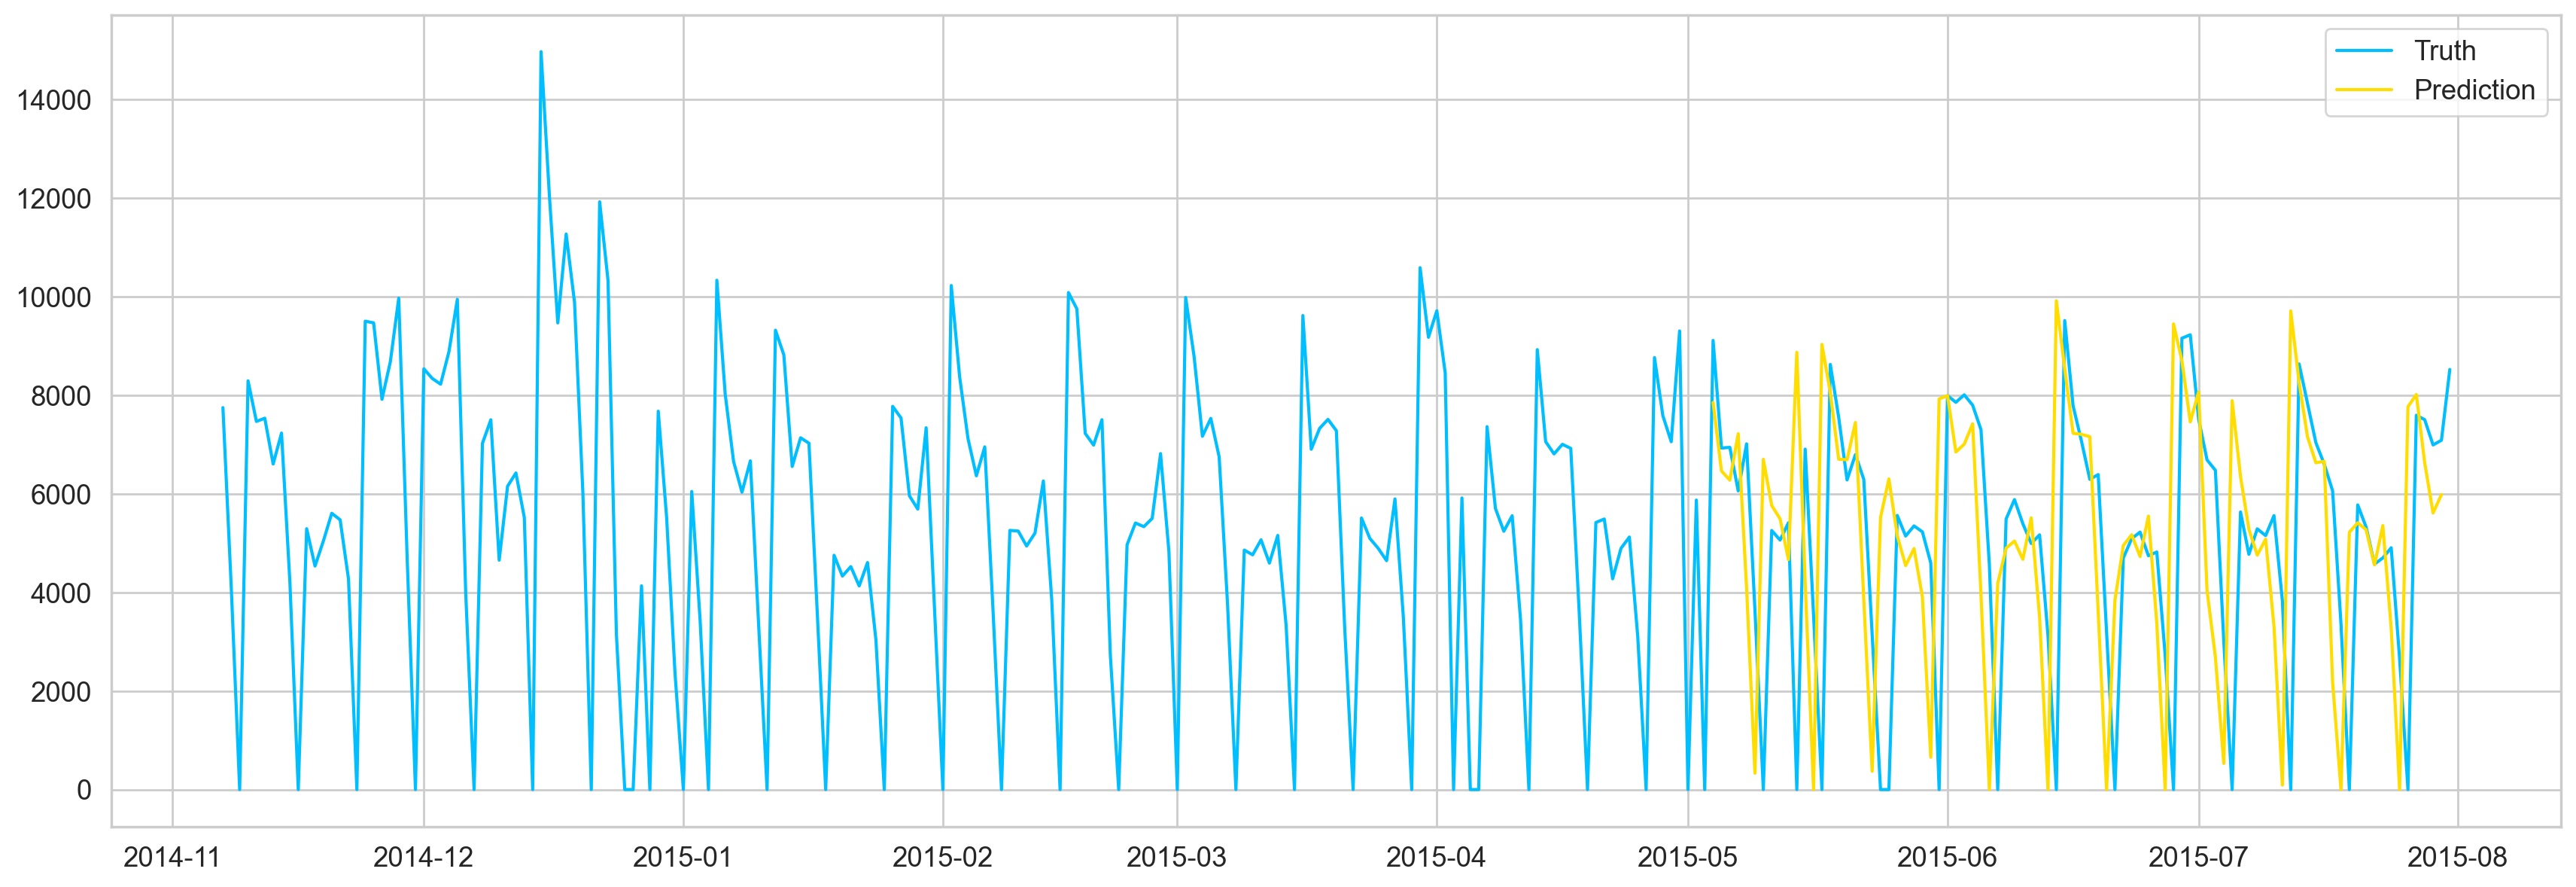

In [6]:
Rossmann_df = pd.read_csv('Rossmann_treated.csv')
Rossmann_df = Rossmann_df [ Rossmann_df ['Store'] == 133]
Rossmann_df.drop(columns = 'Customers', inplace = True)

#makes SHAP calculations for all stores inside the rossmann_treated dataset if removed the [:1]

#to omit outputs
#with io.capture_output() as captured:
df = Rossmann_df.drop(columns  = 'Date')
sales_dependencies = {}
dic = {}

#return all columns names ('features') except for customers, since it's not an available 
#information for future points
features_df = features_dataframe(df,list(df.columns)) 
#returns dataframe with the features to be analised

#split into test and train and minmaxscaler
train_df, test_df, train_size =  train_test_spliter(105,features_df)
train_df, test_df, scaler = data_scaler(train_df,test_df)
#make sequences with the data
train_sequences = create_sequences(train_df,TGT,SEQUENCE_LENGTH)
test_sequences = create_sequences (test_df,TGT,SEQUENCE_LENGTH)

#trains the model and store the most recent checkpoints removing previous ones if existing
data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
data_module.setup()
train_dataset = Dataset(train_sequences)
test_dataset = Dataset(test_sequences)
model = SalesPredictor(n_features = train_df.shape[1])

if Train == True:
    
    try:
        os.remove(f"{folder_path}/Checkpoints/Rossmann_sales_LSTM.ckpt")
    except:
        pass
    
    checkpoint_callback = ModelCheckpoint(
        dirpath = f'{folder_path}/Checkpoints',
        filename = f'Rossmann_sales_LSTM',
        save_top_k = 1,
        verbose = False ,
        monitor = 'val_loss',
        mode = 'min'
    )
    logger = TensorBoardLogger('lightning_logs', name = 'btc-price')
    early_stopping_callback = EarlyStopping(monitor= 'val_loss', patience = PATIENCE)
    trainer = pl.Trainer(
        logger = logger,
        callbacks=[early_stopping_callback, checkpoint_callback],
        max_epochs = N_EPOCHS,
        gpus = 0,
    )
    trainer.fit(model, data_module)

#load the best model from checkpoint
trained_model = SalesPredictor.load_from_checkpoint(
f'Predictions/grid_search_allfeatures/Checkpoints/Rossmann_LSTM_hidden32.ckpt',
n_features = train_df.shape[1]
)

predictions = []
labels = []

for item in test_dataset:
    sequence = item['sequence']
    label = item['label']

    if len(predictions) > 15:
        for j in range(15):
            sequence[-15+j,0] = float(predictions[-15+j])
    else: 
        for j in range(len(predictions)):
            sequence[-len(predictions)+j,0] = float(predictions[-len(predictions)+j])

    _,output = trained_model(sequence.unsqueeze(dim=0))
    predictions.append(output.item())
    labels.append(label.item())



descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = scaler.min_[0], scaler.scale_[0]

predictions_descaled = descale(descaler,predictions)
labels_descaled = descale(descaler,labels)

test_data = df[train_size+1:]
test_sequences_data = test_data.iloc[SEQUENCE_LENGTH:]

dates = matplotlib.dates.date2num(Rossmann_df.iloc[-len(predictions_descaled):].Date.tolist())
full_dates = matplotlib.dates.date2num(Rossmann_df.Date.tolist())

predictions_descaled = np.where(predictions_descaled<0, 0, predictions_descaled)


dic = {}
dic[f'store_truth'] = Rossmann_df[TGT]
dic[f'store_truth_dates'] = full_dates
truth_df = pd.DataFrame.from_dict(dic)

dic= {}
dic[f'store_pred'] = predictions_descaled
dic[f'store_pred_dates'] = dates
prediction_df = pd.DataFrame.from_dict(dic)
prediction_df['store_pred'] =prediction_df['store_pred'].shift(-1)

plt.figure(figsize=(21, 7))
plt.plot_date(truth_df.iloc[-3*len(prediction_df):,1],truth_df.iloc[-3*len(prediction_df):,0],'-', label='Truth')
plt.plot_date(prediction_df.iloc[:,1],prediction_df.iloc[:,0],'-',label ='Prediction')
plt.legend()
plt.show();

In [7]:

if Correlation == True:
    iteration_start = time.monotonic()
    correlation_df = pd.DataFrame(list(Rossmann_df.columns),columns = ['all_features'])
    
    corr_values = [0.0,0.05,0.10,0.15,0.20,0.25]
    correlation_dependencies = {} 

    for cor_th in corr_values:  
        Tgt_corr = Rossmann_df.corr()[abs(Rossmann_df.corr()) > cor_th]
        features = Tgt_corr[Tgt_corr[TGT].notnull()].index
        
        df = pd.DataFrame(features, columns = [f'correlation_th_=_{cor_th}'])
        correlation_df = correlation_df.join(df,how='left')

    display(correlation_df)
    
    correlation_df.to_csv(f"{folder_path}/correlation_df.csv",index = False)
    iteration_end = time.monotonic()
    
    run_time_corr = iteration_end - iteration_start
    %store run_time_corr
    print(run_time_corr)
    
else:
    correlation_df = pd.read_csv(f"{folder_path}/correlation_df.csv")
    %store -r run_time_corr
    
    print(run_time_corr)
    display(correlation_df)

,all_features,correlation_th_=_0.0,correlation_th_=_0.05,correlation_th_=_0.1,correlation_th_=_0.15,correlation_th_=_0.2,correlation_th_=_0.25
0,Store,DayOfWeek,DayOfWeek,DayOfWeek,DayOfWeek,DayOfWeek,DayOfWeek
1,DayOfWeek,Sales,Sales,Sales,Sales,Sales,Sales
2,Date,Open,Open,Open,Open,Open,Open
3,Sales,Promo,Promo,Promo,Promo,Promo,Promo
4,Open,SchoolHoliday,SchoolHoliday,SchoolHoliday,SchoolHoliday,StateHoliday_0,StateHoliday_0
5,Promo,CompetitionDistance,CompetitionDistance,CompetitionDistance,StateHoliday_0,StateHoliday_a,NaN
6,SchoolHoliday,year,year,StateHoliday_0,StateHoliday_a,NaN,NaN
7,Promo2,month,day,StateHoliday_a,NaN,NaN,NaN
8,CompetitionOpenSinceYear,day,StateHoliday_0,StateHoliday_b,NaN,NaN,NaN
9,CompetitionDistance,week,StateHoliday_a,StateHoliday_c,NaN,NaN,NaN


Stored 'run_time_corr' (float)
0.17199999978765845


In [8]:
if BorutaGB == True:
    iteration_start = time.monotonic()
    
    borutaGB_df = pd.DataFrame(list(Rossmann_df.columns),columns = ['all_features'])

    df = Rossmann_df.drop(columns  = 'Date')
    #print(df.columns)

    estimator = GradientBoostingRegressor(n_iter_no_change = 50,
                                          max_depth = 7)
    boruta = BorutaPy(estimator = estimator,n_estimators = 100, max_iter =100)
    features  = list(Rossmann_df.columns)

    features_df = features_dataframe(df,list(df.columns))

    train_df, test_df, train_size =  train_test_spliter(105,features_df)
    train_df, test_df, scaler = data_scaler(train_df,test_df)
    train_sequences = create_sequences (train_df,TGT,SEQUENCE_LENGTH)
    test_sequences = create_sequences (test_df,TGT,SEQUENCE_LENGTH)
    data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
    data_module.setup()

    train_dataset = Dataset(train_sequences)
    test_dataset = Dataset(test_sequences)

    data = dict_to_dataframe(train_dataset, SEQUENCE_LENGTH)

    boruta.fit(np.array(data.iloc[:,:-1]),np.array(data.iloc[:,-1]))

    important = list(data.iloc[:,:-1].columns[boruta.support_])
    important = [i[0][11:] for i in important]
    important = list(set(important)) 

    unimportant = list(data.iloc[:,:-1].columns[boruta.support_weak_])
    unimportant = [i[0][11:] for i in unimportant]
    unimportant = list(set(unimportant))

    tentative = list(data.iloc[:,:-1].columns[~(boruta.support_|boruta.support_weak_)])
    tentative = [i[0][11:] for i in tentative]
    tentative = list(set(tentative)) 

    for i in important:
        if i in unimportant:
            unimportant.remove(i)
    for i in important:
        if i in tentative:
            tentative.remove(i)
    for i in unimportant:
        if i in tentative:
            tentative.remove(i)

    important_df = pd.DataFrame(important, columns=[f'important'])
    unimportant_df = pd.DataFrame(unimportant, columns=[f'unimportant'])
    tentative_df = pd.DataFrame(tentative, columns=[f'tentative'])

    borutaGB_df = borutaGB_df.join([important_df,unimportant_df, tentative_df],how='left')

    display(borutaGB_df)
    borutaGB_df.to_csv(f"{folder_path}/borutaGB_df.csv",index = False)
    iteration_end = time.monotonic()
    
    run_time_borutaGB = iteration_end - iteration_start
    %store run_time_borutaGB
    print(run_time_borutaGB)
    
else:
    %store -r run_time_borutaGB
    borutaGB_df = pd.read_csv(f"{folder_path}/borutaGB_df.csv")
    
    print(run_time_borutaGB)
    display(borutaGB_df)

,all_features,important,unimportant,tentative
0,Store,Sales,week,StateHoliday_c
1,DayOfWeek,DayOfWeek,NaN,CompetitionDistance
2,Date,Promo,NaN,StoreType_c
3,Sales,day,NaN,StateHoliday_b
4,Open,NaN,NaN,Assortment_c
5,Promo,NaN,NaN,StoreType_a
6,SchoolHoliday,NaN,NaN,CompetitionOpenSinceYear
7,Promo2,NaN,NaN,Store
8,CompetitionOpenSinceYear,NaN,NaN,have_competition
9,CompetitionDistance,NaN,NaN,StateHoliday_a


Stored 'run_time_borutaGB' (float)
169.81300000008196


In [ ]:
if BorutaRF == True:
    iteration_start = time.monotonic()
    
    borutaRF_df = pd.DataFrame(list(Rossmann_df.columns),columns = ['all_features'])
    
    df = Rossmann_df.drop(columns  = 'Date')

    estimator = RandomForestRegressor()
    boruta = BorutaPy(estimator = estimator,n_estimators = 100, max_iter =100)

    features  = list(Rossmann_df.columns)

    features_df = features_dataframe(df,list(df.columns))

    train_df, test_df, train_size =  train_test_spliter(105,features_df)
    train_df, test_df, scaler = data_scaler(train_df,test_df)
    train_sequences = create_sequences (train_df,TGT,SEQUENCE_LENGTH)
    test_sequences = create_sequences (test_df,TGT,SEQUENCE_LENGTH)
    data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
    data_module.setup()

    train_dataset = Dataset(train_sequences)
    test_dataset = Dataset(test_sequences)

    data = dict_to_dataframe(train_dataset, SEQUENCE_LENGTH)

    boruta.fit(np.array(data.iloc[:,:-1]),np.array(data.iloc[:,-1]))

    important = list(data.iloc[:,:-1].columns[boruta.support_])
    important = [i[0][11:] for i in important]
    important = list(set(important)) 

    unimportant = list(data.iloc[:,:-1].columns[boruta.support_weak_])
    unimportant = [i[0][11:] for i in unimportant]
    unimportant = list(set(unimportant))

    tentative = list(data.iloc[:,:-1].columns[~(boruta.support_|boruta.support_weak_)])
    tentative = [i[0][11:] for i in tentative]
    tentative = list(set(tentative)) 

    for i in important:
        if i in unimportant:
            unimportant.remove(i)
    for i in important:
        if i in tentative:
            tentative.remove(i)
    for i in unimportant:
        if i in tentative:
            tentative.remove(i)

    important_df = pd.DataFrame(important, columns=[f'important'])
    unimportant_df = pd.DataFrame(unimportant, columns=[f'unimportant'])
    tentative_df = pd.DataFrame(tentative, columns=[f'tentative'])

    borutaRF_df = borutaRF_df.join([important_df,unimportant_df, tentative_df],how='left')

    display(borutaRF_df)
    borutaRF_df.to_csv(f"{folder_path}/borutaRF_df.csv",index = False)
    
    iteration_end = time.monotonic()

    run_time_borutaRF = iteration_end - iteration_start
    %store run_time_borutaRF
    print(run_time_borutaRF)
else:
    %store -r run_time_borutaRF
    print(run_time_borutaRF)
    
    borutaRF_df = pd.read_csv(f"{folder_path}/borutaRF_df.csv")
    display(borutaRF_df)

In [ ]:
if BorutaSHAPGB == True:
    iteration_start = time.monotonic()
    borutaSHAPGB_df = pd.DataFrame(list(Rossmann_df.columns),columns = ['all_features'])
    for i in tqdm(range(1)):
        estimator = GradientBoostingRegressor(n_iter_no_change = 50,
                                              max_depth = 7)
        selector = BorutaShap(estimator,importance_measure = 'shap', classification = False)

        df = Rossmann_df.drop(columns  = 'Date')

        features  = list(Rossmann_df.columns)

        features_df = features_dataframe(df,list(df.columns))

        train_df, test_df, train_size =  train_test_spliter(105,features_df)
        train_df, test_df, scaler = data_scaler(train_df,test_df)
        train_sequences = create_sequences (train_df,TGT,SEQUENCE_LENGTH)
        test_sequences = create_sequences (test_df,TGT,SEQUENCE_LENGTH)
        data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
        data_module.setup()

        train_dataset = Dataset(train_sequences)
        test_dataset = Dataset(test_sequences)

        data = dict_to_dataframeBSHAP(train_dataset, SEQUENCE_LENGTH)

        with io.capture_output() as captured:
            selector.fit(data.iloc[:,:-1], data.iloc[:,-1], n_trials=100,
                        sample=False, train_or_test='train');

        important = list(selector.accepted)
        important = [i[11:] for i in important]
        important = list(set(important)) 

        unimportant = list(selector.rejected)
        unimportant = [i[11:] for i in unimportant]
        unimportant = list(set(unimportant))
        
        tentative = list(selector.tentative)
        tentative = [i[11:] for i in tentative]
        tentative = list(set(tentative))

        
        for i in important:
            if i in unimportant:
                unimportant.remove(i)
        for i in important:
            if i in tentative:
                tentative.remove(i)
        for i in unimportant:
            if i in tentative:
                tentative.remove(i)

        important_df = pd.DataFrame(important, columns=[f'important'])
        unimportant_df = pd.DataFrame(unimportant, columns=[f'unimportant'])
        tentative_df = pd.DataFrame(tentative, columns=[f'tentative'])
        
        borutaSHAPGB_df = borutaSHAPGB_df.join([important_df,unimportant_df, tentative_df],how='left')
        
    display(borutaSHAPGB_df)
    borutaSHAPGB_df.to_csv(f"{folder_path}/borutaSHAPGB_df.csv",index = False)
    
    iteration_end = time.monotonic()

    run_time_borutaSHAPGB = iteration_end - iteration_start
    %store run_time_borutaSHAPGB
    print(run_time_borutaSHAPGB)
    
else:
    %store -r run_time_borutaSHAPGB
    print(run_time_borutaSHAPGB)
    
    borutaSHAPGB_df = pd.read_csv(f"{folder_path}/borutaSHAPGB_df.csv")
    display(borutaSHAPGB_df)

In [ ]:
if BorutaSHAPRF == True:
    iteration_start = time.monotonic()
    borutaSHAPRF_df = pd.DataFrame(list(Rossmann_df.columns),columns = ['all_features'])
    
    for i in tqdm(range(1)):
        estimator = RandomForestRegressor(max_depth = 7)
        selector = BorutaShap(estimator,importance_measure = 'shap', classification = False)

        df = Rossmann_df.drop(columns  = 'Date')

        features  = list(Rossmann_df.columns)

        features_df = features_dataframe(df,list(df.columns))

        train_df, test_df, train_size =  train_test_spliter(105,features_df)
        train_df, test_df, scaler = data_scaler(train_df,test_df)
        train_sequences = create_sequences (train_df,TGT,SEQUENCE_LENGTH)
        test_sequences = create_sequences (test_df,TGT,SEQUENCE_LENGTH)
        data_module = SalesDataModule(train_sequences, test_sequences, batch_size = BATCH_SIZE)
        data_module.setup()

        train_dataset = Dataset(train_sequences)
        test_dataset = Dataset(test_sequences)

        data = dict_to_dataframeBSHAP(train_dataset, SEQUENCE_LENGTH)

        with io.capture_output() as captured:
            selector.fit(data.iloc[:,:-1], data.iloc[:,-1], n_trials=100,
                        sample=False, train_or_test='train');

        important = list(selector.accepted)
        important = [i[11:] for i in important]
        important = list(set(important)) 

        unimportant = list(selector.rejected)
        unimportant = [i[11:] for i in unimportant]
        unimportant = list(set(unimportant))
        
        tentative = list(selector.tentative)
        tentative = [i[11:] for i in tentative]
        tentative = list(set(tentative))

        
        for i in important:
            if i in unimportant:
                unimportant.remove(i)
        for i in important:
            if i in tentative:
                tentative.remove(i)
        for i in unimportant:
            if i in tentative:
                tentative.remove(i)

        important_df = pd.DataFrame(important, columns=[f'important'])
        unimportant_df = pd.DataFrame(unimportant, columns=[f'unimportant'])
        tentative_df = pd.DataFrame(tentative, columns=[f'tentative'])
        
        borutaSHAPRF_df = borutaSHAPRF_df.join([important_df,unimportant_df, tentative_df],how='left')
        
    display(borutaSHAPRF_df)
    borutaSHAPRF_df.to_csv(f"{folder_path}/borutaSHAPRF_df.csv",index = False)
    iteration_end = time.monotonic()

    run_time_borutaSHAPRF = iteration_end - iteration_start
    %store run_time_borutaSHAPRF
    print(run_time_borutaSHAPRF)
    
else:
    %store -r run_time_borutaSHAPRF
    print(run_time_borutaSHAPRF)
    
    borutaSHAPRF_df = pd.read_csv(f"{folder_path}/borutaSHAPRF_df.csv")
    display(borutaSHAPRF_df)

In [ ]:
LSTM_SHAP = False
if LSTM_SHAP == True:   
    iteration_start = time.monotonic()
    kmeans = shap.kmeans(train_df,5)
    #explainer
    explainer = shap.KernelExplainer(LSTM_predict, kmeans)
    #explanation
    shap_values = explainer.shap_values(train_df[-365:])
    #return a FEATURES_TO_USE numpber of features ordered by average shap value
    
    sorted_avg_shap, top_features_dic = return_shap_features(shap_values,train_df,30)
    shap_per_feature = pd.DataFrame.from_dict(sorted_avg_shap, orient='index', columns=['Importance'])
    shap_per_feature.to_csv(f"{folder_path}/Features_avg_LSTMSHAP.csv")
    
    max_shap_df = return_shap_max (shap_values,train_df)
    max_shap_df.to_csv(f"{folder_path}/Features_inst_LSTMSHAP.csv")
    
    ExplanationSHAP = shap.Explanation(values=shap_values, data=train_df[-365:])
    
    %store ExplanationSHAP
    %store shap_values
    
    iteration_end = time.monotonic()

    run_time_SHAPLSTM = iteration_end - iteration_start
    %store run_time_SHAPLSTM
    print(run_time_SHAPLSTM)
    
else:
    %store -r run_time_SHAPLSTM
    print(run_time_SHAPLSTM)
    
    %store -r ExplanationSHAP
    %store -r shap_values
    
max_shap_df = return_shap_max (shap_values,train_df)

sorted_avg_shap, top_features_dic = return_shap_features(shap_values,train_df,30)

display(max_shap_df)
display(sorted_avg_shap)

shap.plots.beeswarm(ExplanationSHAP,max_display = 18)
plt.show()

ExplanationSHAP.feature_names = list(ExplanationSHAP.data.columns)
shap.plots.heatmap(ExplanationSHAP,max_display=18)
plt.show()

In [ ]:
if LSTM_LIME_ == True:
    iteration_start = time.monotonic()
    
    explainer = shap.explainers.other.LimeTabular(LSTM_predict,train_df[-365:],'regression')
    lime = LIME_Explainer(90)
    lime_df = pd.DataFrame(lime)
    lime_df = np.abs(lime_df)
    
    plt.ylabel('Features')
    plt.xlabel('Instances')
    
    sns.heatmap(lime_df.T,cmap='Blues')
    plt.show()
    
    %store lime_df
    
    lime_df_single = lime_df
    
    for col in lime_df.columns:
        lime_df_single[col] = np.sum(np.abs(lime_df_single[col]))/len(lime_df_single[col])
    
    plt.ylabel('Features')
    plt.xlabel('Instances')
    
    sns.heatmap(lime_df_single.T,cmap='Blues')
    plt.show()
        
    lime_df_single = lime_df_single.iloc[0]
    lime_df_single  = lime_df_single.sort_values(ascending=False)

    lime_df_single.to_csv(f"{folder_path}/Features_LSTMLIME.csv", header = ['LIME_value'])
    
        
    
    %store lime_df_single
    iteration_end = time.monotonic()

    run_time_LIMELSTM = iteration_end - iteration_start
    
    
    
    %store run_time_LIMELSTM
    print(run_time_LIMELSTM)
    
else:
    %store -r run_time_LIMELSTM
    print(run_time_LIMELSTM)
    
    %store -r lime_df
    %store -r lime_df_single
    
    sns.heatmap(lime_df.T,cmap='Blues')
    plt.show()
    
    display(lime_df_single)

In [ ]:
df_og = pd.read_csv('Rossmann_treated.csv')
df_og = df_og [df_og ['Store'] == 133]
df_og.drop(columns = '')

data1=df_og.iloc[:-89,:]
data2=df_og.iloc[-89:,:]

data1.drop(columns = 'Date',inplace = True)
data2.drop(columns = 'Date',inplace = True)

target = TGT
cols = list(data1.columns)

train_size = data1.shape[0]
val_size = 89
depth = 15
batch_size = 7
prediction_horizon = 1

X_train1 = np.zeros((len(data1), depth, len(cols)))
y_train1 = np.zeros((len(data1), 1))

for i, name in enumerate(cols):
    for j in range(depth):
        X_train1[:, j, i] = data1[name].shift(depth - j - 1).fillna(method="bfill")
y_train1 = data1[target].shift(-prediction_horizon).fillna(method='ffill')

X_train1 = X_train1[depth:-prediction_horizon]
y_train1 = y_train1[depth:-prediction_horizon]

X2 = np.zeros((len(data2), depth, len(cols)))
y2 = np.zeros((len(data2), 1))

for i, name in enumerate(cols):
    for j in range(depth):
        X2[:, j, i] = data2[name].shift(depth - j - 1).fillna(method="bfill")
y2 = data2[target].shift(-prediction_horizon).fillna(method='ffill')

X_train2 = X2[:train_size - len(data1)]
y_train2 = y2[:train_size - len(data1)]

X_val = X2[train_size - len(data1):train_size - len(data1) + val_size]
y_val = y2[train_size - len(data1):train_size - len(data1) + val_size]

X_test = X2[train_size - len(data1) + val_size:]
y_test = y2[train_size - len(data1) + val_size:]

X_train2 = X_train2[depth:]
y_train2 = y_train2[depth:]

X_train = np.concatenate([X_train1, X_train2], axis=0)
y_train = np.concatenate([y_train1, y_train2], axis=0)

X_train_min, y_train_min = X_train.min(axis=0), y_train.min(axis=0)
X_train_max, y_train_max = X_train.max(axis=0), y_train.max(axis=0)

X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val.values)
y_test_t = torch.Tensor(y_test.values)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=batch_size)



In [ ]:
epochs = 10001
loss = nn.MSELoss()
patience = 50
min_val_loss = 9999
counter = 0

IMV_Tensor = True
if IMV_Tensor == True:
    iteration_start = time.monotonic()
    
    model = IMVTensorLSTM(X_train.shape[2], 1, 32)
    opt = torch.optim.Adam(model.parameters(), lr=0.05)
    epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)
    
    for i in tqdm(range(epochs)):
        mse_train = 0
        for batch_x, batch_y in train_loader :
            batch_x = batch_x
            batch_y = batch_y
            opt.zero_grad()
            y_pred, alphas_Tensor, betas_Tensor = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        epoch_scheduler.step()
        #with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        alphas_Tensor = []
        betas_Tensor = []

        for batch_x, batch_y in val_loader:
            batch_x = batch_x
            batch_y = batch_y
            output, a, b = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            alphas_Tensor.append(a.detach().cpu().numpy())
            betas_Tensor.append(b.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        alphas_Tensor = np.concatenate(alphas_Tensor)
        betas_Tensor = np.concatenate(betas_Tensor)

        if min_val_loss > mse_val**0.5:
            min_val_loss = mse_val**0.5
            print("Saving...")
            torch.save(model.state_dict(), "imv_full_lstm.pt")
            counter = 0
        else: 
            counter += 1

        if counter == patience:
            preds = preds*(y_train_max - y_train_min) + y_train_min
            true = true*(y_train_max - y_train_min) + y_train_min
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(20, 10))
            plt.plot(preds)
            plt.plot(true)
            plt.show()
            break
        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
        if(i % 10 == 0):
            preds = preds*(y_train_max - y_train_min) + y_train_min
            true = true*(y_train_max - y_train_min) + y_train_min
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(20, 10))
            plt.plot(preds)
            plt.plot(true)
            plt.show()

    alphas_Tensor = alphas_Tensor.mean(axis=0)
    betas_Tensor = betas_Tensor.mean(axis=0)

    alphas_Tensor = alphas_Tensor[..., 0]
    betas_Tensor = betas_Tensor[..., 0]

    alphas_Tensor = alphas_Tensor.transpose(1, 0)

    X_train_t = torch.Tensor(X_train)

    fig, ax = plt.subplots(figsize=(15, 30))
    im = ax.imshow(alphas_Tensor)
    ax.set_xticks(np.arange(X_train_t.shape[1]))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
    ax.set_yticklabels(cols)
    for i in range(len(cols)):
        for j in range(X_train_t.shape[1]):
            text = ax.text(j, i, round(alphas_Tensor[i, j], 3),
                           ha="center", va="center", color="w")
    ax.set_title("Importance of features and timesteps")
    #fig.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title("Feature importance")
    plt.bar(range(len(cols)), betas_Tensor)
    plt.xticks(range(len(cols)), cols, rotation=90);
    plt.show()
    
    IMV_T_dic = {'features': cols , 'Importance': betas_Tensor} 
    IMV_T_df = pd.DataFrame(IMV_T_dic)
    IMV_T_df  = IMV_T_df.sort_values(ascending=False, by ='Importance')

    IMV_T_df.to_csv(f"{folder_path}/Features_IMV_Tensor.csv")
    
    %store betas_Tensor
    %store alphas_Tensor
    %store IMV_T_df
    
    iteration_end = time.monotonic()

    run_time_IMVTensor = iteration_end - iteration_start
    %store run_time_IMVTensor
    print(run_time_IMVTensor)
    
    
    
else:
    %store -r betas_Tensor
    %store -r alphas_Tensor
    %store -r IMV_T_df
    
    display(IMV_T_df)
    
    X_train_t = torch.Tensor(X_train)

    fig, ax = plt.subplots(figsize=(15, 30))
    im = ax.imshow(alphas_Tensor)
    ax.set_xticks(np.arange(X_train_t.shape[1]))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
    ax.set_yticklabels(cols)
    for i in range(len(cols)):
        for j in range(X_train_t.shape[1]):
            text = ax.text(j, i, round(alphas_Tensor[i, j], 3),
                           ha="center", va="center", color="w")
    ax.set_title("Importance of features and timesteps")
    #fig.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title("Feature importance")
    plt.bar(range(len(cols)), betas_Tensor)
    plt.xticks(range(len(cols)), cols, rotation=90);
    plt.show()
    
    %store -r run_time_IMVTensor
    print(run_time_IMVTensor)
    

In [ ]:
epochs = 10001
loss = nn.MSELoss()
patience = 50
min_val_loss = 9999
counter = 0

if IMV_Full == True:
    iteration_start = time.monotonic()
    
    IMVFullLSTM(X_train.shape[2], 1, 32)
    opt = torch.optim.Adam(model.parameters(), lr=0.05)
    epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)
    
    for i in tqdm(range(epochs)):
        mse_train = 0
        for batch_x, batch_y in train_loader :
            batch_x = batch_x
            batch_y = batch_y
            opt.zero_grad()
            y_pred, alphas_Full, betas_Full = model(batch_x)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        epoch_scheduler.step()
        #with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        alphas_Full = []
        betas_Full = []

        for batch_x, batch_y in val_loader:
            batch_x = batch_x
            batch_y = batch_y
            output, a, b = model(batch_x)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            alphas_Full.append(a.detach().cpu().numpy())
            betas_Full.append(b.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        alphas_Full = np.concatenate(alphas_Full)
        betas_Full = np.concatenate(betas_Full)

        if min_val_loss > mse_val**0.5:
            min_val_loss = mse_val**0.5
            print("Saving...")
            torch.save(model.state_dict(), "imv_full_lstm.pt")
            counter = 0
        else: 
            counter += 1

        if counter == patience:
            preds = preds*(y_train_max - y_train_min) + y_train_min
            true = true*(y_train_max - y_train_min) + y_train_min
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(20, 10))
            plt.plot(preds)
            plt.plot(true)
            plt.show()
            break
        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
        if(i % 10 == 0):
            preds = preds*(y_train_max - y_train_min) + y_train_min
            true = true*(y_train_max - y_train_min) + y_train_min
            mse = mean_squared_error(true, preds)
            mae = mean_absolute_error(true, preds)
            print("mse: ", mse, "mae: ", mae)
            plt.figure(figsize=(20, 10))
            plt.plot(preds)
            plt.plot(true)
            plt.show()

    alphas_Full = alphas_Full.mean(axis=0)
    betas_Full = betas_Full.mean(axis=0)

    alphas_Full = alphas_Full[..., 0]
    betas_Full = betas_Full[..., 0]

    alphas_Full = alphas_Full.transpose(1, 0)

    X_train_t = torch.Tensor(X_train)

    fig, ax = plt.subplots(figsize=(15, 30))
    im = ax.imshow(alphas_Full)
    ax.set_xticks(np.arange(X_train_t.shape[1]))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
    ax.set_yticklabels(cols)
    for i in range(len(cols)):
        for j in range(X_train_t.shape[1]):
            text = ax.text(j, i, round(alphas_Full[i, j], 3),
                           ha="center", va="center", color="w")
    ax.set_title("Importance of features and timesteps")
    #fig.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title("Feature importance")
    plt.bar(range(len(cols)), betas_Full)
    plt.xticks(range(len(cols)), cols, rotation=90);
    plt.show()
    
    IMV_F_dic = {'features': cols , 'Importance': betas_Full} 
    IMV_F_df = pd.DataFrame(IMV_F_dic)
    IMV_F_df  = IMV_F_df.sort_values(ascending=False, by ='Importance')

    IMV_F_df.to_csv(f"{folder_path}/Features_IMV_Full.csv")
    
    %store betas_Tensor
    %store alphas_Tensor
    %store IMV_F_df
    
    %store betas_Full
    %store alphas_Full
    
    iteration_end = time.monotonic()

    run_time_IMVFull = iteration_end - iteration_start
    %store run_time_IMVFull
    print(run_time_IMVFull)
    
else:
    %store -r betas_Tensor
    %store -r alphas_Tensor
    %store -r IMV_F_df
    
    display(IMV_F_df)
    
    X_train_t = torch.Tensor(X_train)

    fig, ax = plt.subplots(figsize=(15, 30))
    im = ax.imshow(alphas_Full)
    ax.set_xticks(np.arange(X_train_t.shape[1]))
    ax.set_yticks(np.arange(len(cols)))
    ax.set_xticklabels(["t-"+str(i) for i in np.arange(X_train_t.shape[1], 0, -1)])
    ax.set_yticklabels(cols)
    for i in range(len(cols)):
        for j in range(X_train_t.shape[1]):
            text = ax.text(j, i, round(alphas_Full[i, j], 3),
                           ha="center", va="center", color="w")
    ax.set_title("Importance of features and timesteps")
    #fig.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.title("Feature importance")
    plt.bar(range(len(cols)), betas_Full)
    plt.xticks(range(len(cols)), cols, rotation=90);
    plt.show()
    
    %store -r run_time_IMVFull
    print(run_time_IMVFull)